<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Using Python to get the latest NEXRAD Composite</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/_images/radar.png" alt="Example Radar Image" style="height: 200px;"></div>

Objective: Visualize the latest available reflectivity data composited data
    
Steps involved:
- Construct the appropriate URL to get the latest data file
- Open the URL using netCDF4-python
- Read the basic metadata
- Create the appropriate CartoPy projection and plot the Radar Reflectivity

In [1]:
# Set-up for notebook
%matplotlib inline

# Some needed imports
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import numpy as np
from netCDF4 import Dataset
from siphon.catalog import TDSCatalog
from metpy.plots import ctables

## Get the latest data URL, grab the metadata, and request the data

In [2]:
# Get today's date...
today = dt.datetime.utcnow()

# ...and use that to assemble the URL and grab the catalog
url = "http://thredds.ucar.edu/thredds/catalog/nexrad/composite/gini/n0r/1km/{}/catalog.xml".format(today.strftime("%Y%m%d"))
cat = TDSCatalog(url)

# Get the list of names of datasets
names = list(cat.datasets.keys())
print(names[:15])

['Level3_Composite_n0r_1km_20161013_2230.gini', 'Level3_Composite_n0r_1km_20161013_2225.gini', 'Level3_Composite_n0r_1km_20161013_2220.gini', 'Level3_Composite_n0r_1km_20161013_2215.gini', 'Level3_Composite_n0r_1km_20161013_2210.gini', 'Level3_Composite_n0r_1km_20161013_2205.gini', 'Level3_Composite_n0r_1km_20161013_2200.gini', 'Level3_Composite_n0r_1km_20161013_2155.gini', 'Level3_Composite_n0r_1km_20161013_2150.gini', 'Level3_Composite_n0r_1km_20161013_2145.gini', 'Level3_Composite_n0r_1km_20161013_2140.gini', 'Level3_Composite_n0r_1km_20161013_2135.gini', 'Level3_Composite_n0r_1km_20161013_2130.gini', 'Level3_Composite_n0r_1km_20161013_2125.gini', 'Level3_Composite_n0r_1km_20161013_2120.gini']


In [3]:
# sort, so that the last dataset is the latest
names.sort()
latest = names[-1]
print(latest)

Level3_Composite_n0r_1km_20161013_2230.gini


In [4]:
# Grab the dataset for the latest
latestDs = cat.datasets[latest]

In [5]:
# Construct a NetCDF dataset using the OPeNDAP access URL
dataset = Dataset(latestDs.access_urls['OPENDAP'])
print(list(dataset.variables.keys()))

['time', 'x', 'y', 'LambertConformal', 'Reflectivity']


In [6]:
dataset.variables['LambertConformal'].ncattrs()

['grid_mapping_name',
 'latitude_of_projection_origin',
 'longitude_of_central_meridian',
 'standard_parallel',
 'earth_radius',
 '_CoordinateTransformType',
 '_CoordinateAxes']

In [7]:
##################
# Projection fun #
##################

# get basic info from the file regarding projection attributes
# see the following for more info on projections as described here:
#   http://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID218
#   http://www.wmo.int/pages/prog/www/WDM/Guides/Guide-binary-2.html
#   [see LAMBERT CONFORMAL SECANT OR TANGENT CONE GRIDS]
#   http://www.unidata.ucar.edu/mailing_lists/archives/netcdf-java/2006/msg00006.html
#   [standard parallels in CDM]
proj = dataset.variables['LambertConformal']
rsphere = proj.earth_radius

# lat_0	: center of desired map domain (in degrees) [Basemap]
# CDM : 'latitude_of_projection_origin'
lat_0 = proj.latitude_of_projection_origin

# lon_0	: center of desired map domain (in degrees) [Basemap]
# CDM : 'longitude_of_central_meridian'
lon_0 = proj.longitude_of_central_meridian

# lat_1, lat_2 : 1st and second parallels [Basemap]
# CDM : 'standard_parallel' - this attr contains both 1st and 2nd
lat_1 = proj.standard_parallel
print(lat_0, lon_0, lat_1, rsphere)

40.0 -100.0 40.0 6371229.0


## Grab the data

In [8]:
# Used to subset the data
xstride = 10
ystride = 10

# download x and y coords and convert them from km to m
x = dataset.variables['x'][::xstride] * 1000.
y = dataset.variables['y'][::ystride] * 1000.

# Grab the reflectivity data. Mask values less than -30 dBz
data = dataset.variables["Reflectivity"][0, 0::ystride, 0::xstride]
data = np.ma.array(data, mask=data<=-30)

## Create the Plot

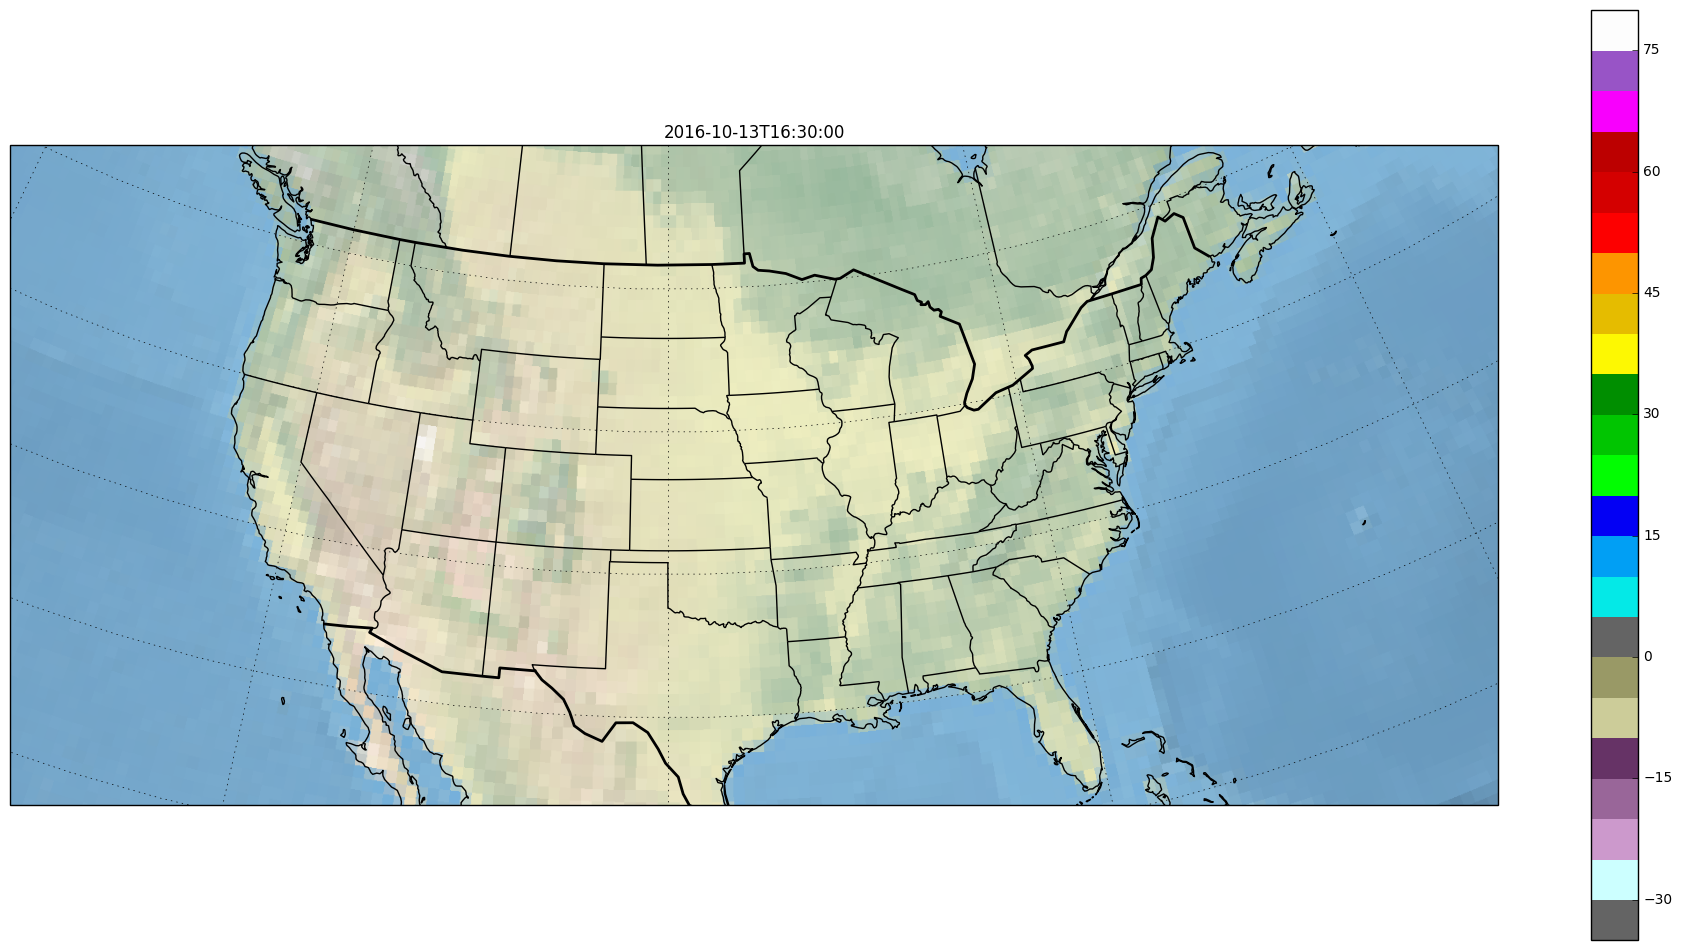

In [10]:
# Set up the projection for the LambertConformal projection we know we have
lcc = cartopy.crs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                   standard_parallels=(lat_0, lat_1))

# Create a large figure and axes with this projection
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(1, 1, 1, projection=lcc)

# Limit to the bounds of the data we have
ax.set_extent([-129., -63., 22., 49.], cartopy.crs.Geodetic())

# Add some map features
ax.stock_img()
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.NaturalEarthFeature(category='cultural',
                                                   name='admin_1_states_provinces_lakes',
                                                   scale='50m', facecolor='none'))
ax.add_feature(cartopy.feature.BORDERS, linewidth='2', edgecolor='black')
ax.gridlines()

# Convert the time to text and add as the title
time = dataset.variables["time"][:][0] / 1000.
title = dt.datetime.fromtimestamp(time).isoformat()
ax.set_title(title)

# Plot the data as an image, using the x and y values we have as the extents of the image
# NOTE: This assumes equal-spaced points
cmap = ctables.registry.get_colortable('NWSReflectivityExpanded')
norm = mpl.colors.Normalize(vmin=-35, vmax=80)
cax = ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()), cmap=cmap,
                norm=norm, origin="upper", transform=lcc)
plt.colorbar(cax);

## Exercise

Using what was done above, plot the digital hybrid reflectivity (DHR):
- Look at http://thredds.ucar.edu/thredds/catalog/nexrad/composite/gini/catalog.html
- Instead of plotting over all of the U.S., limit to an area of interest
- DHR was chosen to keep the colormap from the NWS the same. Can also look at:
    - Echo Tops (EET)
    - Digital VIL (DVL)
    - Others in catalog
- ***Bonus points***: Plot the data into a new coordinate system, like Orthographic